In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import timeit
import glob
import dask
from multiprocessing.pool import ThreadPool

In [2]:
# Load model output of sea surface temperature (SST) from netCDF files
datapath = '/mnt/disk2/data/ESM2G/'
files = glob.glob(datapath + 'tos*historical*.nc')
files.sort()
# data  = xr.open_dataset(datapath + 'tos_Omon_GFDL-ESM2G_historical_r1i1p1_200101-200512.nc')
data = xr.open_mfdataset(files)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Slow variant: 572.440731


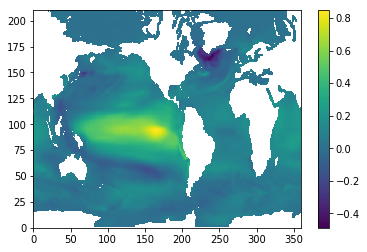

In [5]:
start_time = timeit.default_timer()
tos = data.tos.load()
ntime,nlat,nlon = tos.shape
elapsed_time = timeit.default_timer() - start_time
print("xarray File I/O: %f" % elapsed_time)
start_time = timeit.default_timer()
# Calculate monthly averages
monthly_average = np.zeros((12,nlat,nlon))
nyears = ntime/12.
for jtime in range(0,ntime):
    current_month = np.mod(jtime,12) # Keep track of which month we're in
    monthly_average[current_month,:,:] = tos[jtime,:,:] + monthly_average[current_month,:,:]
monthly_average[:,:,:] = monthly_average[:,:,:]/nyears
# Calculate monthly anomalies by subtracting the monthly climatology
tos_anomaly = np.zeros((ntime,nlat,nlon))
for jtime in range(0,ntime):
    current_month = np.mod(jtime,12) # Keep track of which month we're in
    tos_anomaly[jtime,:,:] = tos[jtime,:,:] - monthly_average[current_month,:,:]
    # Calculate the El-Nino Southern Oscillation (ENSO) Index from the Nino 3.4 region
nino_minlat = -5  ; nino_maxlat = 5
nino_minlon = -170 ; nino_maxlon = -120
nino_index = np.zeros((ntime,1))
total_area = 0
for jlat in range(0,nlat):
    if (np.mod(jlat,10)==0):
        print(jlat)
    for jlon in range(0,nlon):
qata.lon[jlat,jlon] >= nino_minlon and data.lon[jlat,jlon] <= nino_maxlon) )
        if (inregion):  
            # This should be an area-weighted average, but for simplicity 
            # we do a naive average based on the total number of points
            total_area = total_area + 1
            for jtime in range(0,ntime):
                nino_index[jtime] = nino_index[jtime] + np.array(tos_anomaly[jtime,jlat,jlon])
nino_index[:] = nino_index[:] / total_area
# Calculate the covariance between the ENSO index and sea surface temperatures
nino_sst_covariance = np.zeros((nlat,nlon))
for jtime in range(0,ntime):
    for jlat in range(0,nlat):
        for jlon in range(0,nlon):
            nino_sst_covariance[jlat,jlon] = (nino_sst_covariance[jlat,jlon] + 
                                              tos_anomaly[jtime,jlat,jlon]*nino_index[jtime])
nino_sst_covariance = nino_sst_covariance/(ntime - 1)
elapsed_time = timeit.default_timer() - start_time
print("Slow variant: %f" % elapsed_time)
plt.pcolormesh(nino_sst_covariance); plt.colorbar(); plt.show()

/home/ashao/miniconda3/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


xarray File I/O: 5.758871
Fast variant: 3.344167


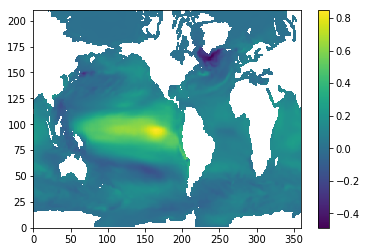

In [3]:
dask.set_options(pool=ThreadPool(4))
start_time = timeit.default_timer()
data = xr.open_mfdataset(files)
data_chunk = data.load()
elapsed_time = timeit.default_timer() - start_time
print("xarray File I/O: %f" % elapsed_time)
start_time = timeit.default_timer()
nino_minlat = -5  ; nino_maxlat = 5
nino_minlon = -170 ; nino_maxlon = -120
monthly_average = data_chunk['tos'].groupby('time.month').mean('time')
tos_anomaly = data_chunk['tos'].groupby('time.month') - monthly_average
nino34_mask = xr.ufuncs.logical_and(
                            xr.ufuncs.logical_and(data.lat>nino_minlat,data.lat<=nino_maxlat),
                            xr.ufuncs.logical_and(data.lon>nino_minlon,data.lon<=nino_maxlon)
                            )
nino_index = tos_anomaly.where( nino34_mask ).mean(('rlat','rlon'))
nino_sst_covariance = (tos_anomaly*nino_index).mean('time')
nino_sst_covariance.compute()
elapsed_time = timeit.default_timer() - start_time
print("Fast variant: %f" % elapsed_time)
plt.clf()
plt.pcolormesh(nino_sst_covariance); plt.colorbar(); plt.show()
plt.plot(nino_index)


In [7]:
data.chunks

Frozen(SortedKeysDict({'time': (60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60), 'bnds': (2,), 'rlat': (21, 21, 21, 21, 21, 21, 21, 21, 21, 21), 'rlon': (36, 36, 36, 36, 36, 36, 36, 36, 36, 36), 'vertices': (4,)}))